In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import joblib
import os

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")

# Ensure model directory exists
os.makedirs("../models", exist_ok=True)

In [2]:
# Load the processed Atlanta dataset from Notebook 01
df = pd.read_csv("../data/processed/atl_long.csv")
print("Data shape:", df.shape)
df.head()

Data shape: (7421, 7)


,RegionName,City,State,CountyName,Date,ZHVI,ZHVI_lag1
0,30303,Atlanta,GA,Fulton County,2000-02-29,132753.778417,131908.654361
1,30303,Atlanta,GA,Fulton County,2000-03-31,132769.323242,132753.778417
2,30303,Atlanta,GA,Fulton County,2000-04-30,133749.246975,132769.323242
3,30303,Atlanta,GA,Fulton County,2000-05-31,134895.565080,133749.246975
4,30303,Atlanta,GA,Fulton County,2000-06-30,138679.048957,134895.565080


In [3]:
# In case Notebook 01 included non-GA cities, we clean again
df = df[
    (df["City"].str.lower() == "atlanta") &
    (df["State"].str.upper() == "GA")
].copy()

print(df[["City", "State"]].drop_duplicates())
print("Filtered dataset shape:", df.shape)

      City State
0  Atlanta    GA
Filtered dataset shape: (7421, 7)


In [4]:
# Convert Date
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Create lags
for lag in [1, 3, 6]:
    df[f"ZHVI_lag{lag}"] = df.groupby("RegionName")["ZHVI"].shift(lag)

# Rolling averages
for window in [3, 6]:
    df[f"ZHVI_roll{window}"] = df.groupby("RegionName")["ZHVI"].transform(lambda x: x.rolling(window).mean())

# Time-based features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# Drop rows with missing lag/roll values
df.dropna(inplace=True)

print("Final feature columns:")
print(df.columns)

Final feature columns:
Index(['RegionName', 'City', 'State', 'CountyName', 'Date', 'ZHVI',
       'ZHVI_lag1', 'ZHVI_lag3', 'ZHVI_lag6', 'ZHVI_roll3', 'ZHVI_roll6',
       'Year', 'Month'],
      dtype='object')


In [5]:
# Choose feature columns
feature_cols = [
    "ZHVI_lag1", "ZHVI_lag3", "ZHVI_lag6",
    "ZHVI_roll3", "ZHVI_roll6", "Year", "Month"
]

X = df[feature_cols]
y = df["ZHVI"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

Training samples: 5816
Testing samples: 1455


In [6]:
model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

print("Model trained successfully")

Model trained successfully


In [7]:
y_pred = model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error: 1425.13
R² Score: 0.9999


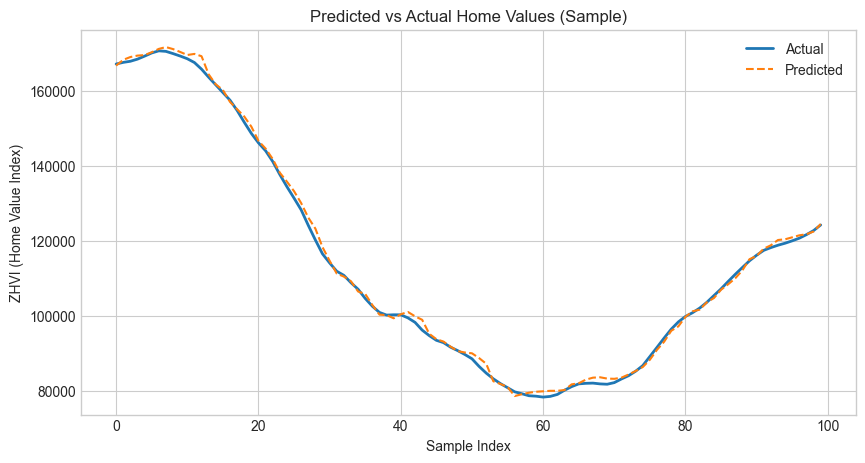

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.values[:100], label="Actual", linewidth=2)
plt.plot(y_pred[:100], label="Predicted", linestyle="--")
plt.title("Predicted vs Actual Home Values (Sample)")
plt.xlabel("Sample Index")
plt.ylabel("ZHVI (Home Value Index)")
plt.legend()
plt.show()

In [9]:
model_path = "../models/random_forest_atlanta.joblib"
joblib.dump(model, model_path)
print(f"Model saved to {model_path}")

Model saved to ../models/random_forest_atlanta.joblib
